In [1]:
import numpy as np
import os
import pandas as pd
import psycopg2
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn import preprocessing
from urllib.parse import urlparse
from urllib import parse
from lib.build_regressions_features_demo import MixedFeatureData
from lib.explore_data import ExploratoryAnalysis
from lib.regressions import MixedClassificationModel

%matplotlib inline
FOLLOWER_URL = os.environ['FOLLOWER_URL']
                          
def make_connection():
    url_output = FOLLOWER_URL
    url = urlparse(url_output)
    conn = psycopg2.connect(
        database=url.path[1:],
        user=url.username,
        password=url.password,
        host=url.hostname
    )
    return conn

# START HERE
## The cell below contains all the mission specific data. Here you will specifity the mission id, the independent variables, the dependent variable, and the definitions of positive and negative outcome.

In [2]:
# CHANGE THESE VALUES
mission_id = "25614"
# ONLY USE SINGLE QUESTIONS FOR DEPENDENT AND INDEPENDENT VARIABLES IN FORMAT 'PART_NUM-QUESTION_NUM'
# ALL "4-4", "4-5","4-6", "4-10","4-11","4-12", "4-13","4-14","4-15","4-17","4-18","4-19","4-21"
continuous_independent_variables = ["4-4", "4-5","4-6", "4-10",
                                    "4-12","4-15",
                                    "4-17","4-18","4-19","4-21"]
# NOTE MULTIPLE QUESTIONS NEED TO BE CATEGORICAL
categorical_independent_variables = []
binary_independent_variables = []
dependent_variable = "4-2"
negative_outcomes = [
"Moderately satisfied",
"Slightly satisfied",
"Neither satisfied nor dissatisfied",
"Slightly dissatisfied",
"Moderately dissatisfied",
"Extremely dissatisfied"
]
positive_outcomes = ["Extremely satisfied"]
demo_independent_variables = ['age']
tag_independent_variables = []
#mutually exclusive scout groups only at this time
scout_group_independent_variables = []
#response_data = pd.read_pickle("mission_" + mission_id + "_data.pkl")
question_response_filtering = {}
grouping = 'user_id'
ethnicity_filters = []
education_filters = []
tag_filters = []
scout_group_filters = ["Apple","Samsung","Pixel","Bose"]

# After entering the information above, go to Cell -> Run All to see your regression results

In [3]:
cnc = make_connection()
questions = pd.read_sql_query(
    """with m_questions as (select id as question_id, label, type, position as question_position,
                            part_id, structure from questions where type in 
                            ('SingleQuestion', 'MultipleQuestion', 'NumberQuestion')
                            and mission_id = """
    + mission_id
    + """),
       m_parts as (select id as part_id, position as part_position from parts where
                   mission_id = """
    + mission_id
    + """)
    select question_id, label, type, question_position, m_parts.part_id, part_position,
    structure from m_questions join m_parts on m_questions.part_id = m_parts.part_id""",
    cnc,
)
print("collected questions")

question_list = (
    "(" + ",".join([str(a) for a in questions["question_id"].tolist()]) + ")"
)
snippets = pd.read_sql_query(
    """select id as snippet_id, user_id, assignment_id from snippets where mission_id = """
    + mission_id,
    cnc,
)
print("collected snippets")
scout_group_names = (
    "("
    + ",".join(["'" + str(sg) + "'" for sg in scout_group_independent_variables])
    + ")"
)
assignments = pd.read_sql_query(
    """select id as assignment_id, user_id from assignments where 
          mission_id = """
    + mission_id
    ,cnc)
assignment_list = "(" + ','.join([str(aid) for aid in assignments['assignment_id'].unique()]) +")"
assignment_groups = pd.read_sql_query(
    """select assignment_id, scout_group_id from assignments_scout_groups
    where assignment_id in """ + assignment_list,
    cnc
)
groups = pd.read_sql_query(
    """select id as scout_group_id, name as scout_group from scout_groups
    """,
    cnc)
scout_groups = pd.merge(
    assignment_groups,
    groups[groups['scout_group'].isin(scout_group_filters)],
    on='scout_group_id'
)
print("collected scout groups")


snippet_list = (
    "(" + ",".join([str(a) for a in snippets["snippet_id"].tolist()]) + ")"
)
responses = pd.read_sql_query(
    """select  id as response_id, snippet_id, question_id, 
    answers from responses where snippet_id in """
    + snippet_list,
    cnc,
)
print("collected responses")
snippets_tags = pd.read_sql_query(
    """Select tag_id, snippet_id from snippets_tags where snippet_id in """
    + snippet_list,
    cnc,
)
tag_list = "(" + ",".join([str(a) for a in snippets_tags["tag_id"].tolist()]) + ")"
tags = pd.read_sql_query(
    """select id as tag_id, name as tag from tags where id in """ + tag_list, cnc
)

snippets_tags = pd.merge(snippets_tags, tags, on="tag_id")
tagged_snippets = pd.merge(snippets, snippets_tags, on="snippet_id", how="left")
user_list = "(" + ",".join([str(a) for a in assignments["user_id"].tolist()]) + ")"
users = pd.read_sql_query(
    """select id as user_id, ethnicity, education, household_income, birthday, gender from users where
                                 id in """
    + user_list,
    cnc,
)
user_snippets = pd.merge(tagged_snippets, users, on="user_id", how="left")
user_snippets = pd.merge(user_snippets, scout_groups, on="assignment_id", how="left")
response_data = pd.merge(responses, questions, on="question_id")
response_data = pd.merge(response_data, user_snippets, on="snippet_id", how="left")
cnc.close

collected questions
collected snippets
collected scout groups
collected responses


<function connection.close>

In [4]:
#response_data.to_pickle('mission_'+mission_id+'_data.pkl')

In [5]:
response_data['birthday'] = response_data['birthday'].astype('datetime64[ns]')

In [6]:
if ethnicity_filters:
    ethnicities = ethnicity_filters
else:
    response_data['ethnicity'] = (
        response_data['ethnicity'].fillna('missing')
    )
    ethnicities = response_data['ethnicity'].unique()

if education_filters:
    educations = education_filters
else:
    response_data['education'] = (
        response_data['education'].fillna('missing')
    )
    educations = response_data['education'].unique()
if tag_filters:
    tags = tag_filters
else:
    response_data['tag'] = (
        response_data['tag'].fillna('None')
    )
    tags = response_data['tag'].unique()
if scout_group_filters:
    scout_groups = scout_group_filters
else:
    response_data['scout_group'] = (
        response_data['scout_group'].fillna('None')
    )
    scout_groups = response_data['scout_group'].unique()
filtered = response_data[(response_data['ethnicity'].isin(ethnicities)) & 
                        (response_data['education'].isin(educations)) &
                        (response_data['tag'].isin(tags)) &
                        (response_data['scout_group'].isin(scout_groups))].copy()
filtered_id_list = []
for question in question_response_filtering:
    part, num = int(question.split('-')[0])-1, int(question.split('-')[1])-1
    response = question_response_filtering[question]
    ids = filtered [(filtered['part_position'] == part) &
                        (filtered['question_position'] == num) &
                        (any([response in x for x in filtered['answers']]))][grouping].unique()
    filtered_id_list = filtered_id_list + list(ids)

In [7]:
if filtered_id_list:
    filtered_all = filtered[filtered["snippet_id"].isin(filtered_id_list)].copy()
else:
    filtered_all = filtered.copy()

In [8]:
print(len(response_data[response_data['part_position'] == 3].groupby('user_id').count()))
print(len(filtered[filtered['part_position'] == 3].groupby('user_id').count()))
print(len(filtered[filtered['part_position'] == 3].drop_duplicates(['user_id','question_id']).groupby(['user_id']).count()))

461
461
461


In [9]:
filtered[filtered['part_position'] == 3].groupby('user_id').first().reset_index().groupby('scout_group').count()

,user_id,response_id,snippet_id,question_id,answers,label,type,question_position,part_id,part_position,structure,assignment_id,tag_id,tag,ethnicity,education,household_income,birthday,gender,scout_group_id
scout_group,,,,,,,,,,,,,,,,,,,,
Apple,114,114,114,114,114,114,114,114,114,114,114,114,0,114,114,114,105,114,114,114
Bose,115,115,115,115,115,115,115,115,115,115,115,115,0,115,115,115,110,115,115,115
Pixel,115,115,115,115,115,115,115,115,115,115,115,115,0,115,115,115,110,114,114,115
Samsung,117,117,117,117,117,117,117,117,117,117,117,117,0,117,117,117,112,117,117,117


In [10]:
fd = MixedFeatureData(
    filtered_all,
    dependent_variable,
    continuous_independent_variables,
    binary_independent_variables,
    categorical_independent_variables,
    positive_outcomes,
    negative_outcomes,
    demo_independent_variables,
    tag_independent_variables,
    scout_group_independent_variables,
    grouping,
)
eda = ExploratoryAnalysis(
    fd.encoded_features,
    fd.independent_variables,
    fd.dependent_variable,
    fd.question_choices(),
)
logistic_regression = MixedClassificationModel(fd)

In [11]:
fd.raw['scout_group'].unique()

array(['Pixel', 'Bose', 'Samsung', 'Apple'], dtype=object)

In [12]:
len(logistic_regression.balanced)

418

## Correlations of Independent Variables
### After viewing these you may want to rethink your independent variable choices

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115321b70>,
      dtype=object)

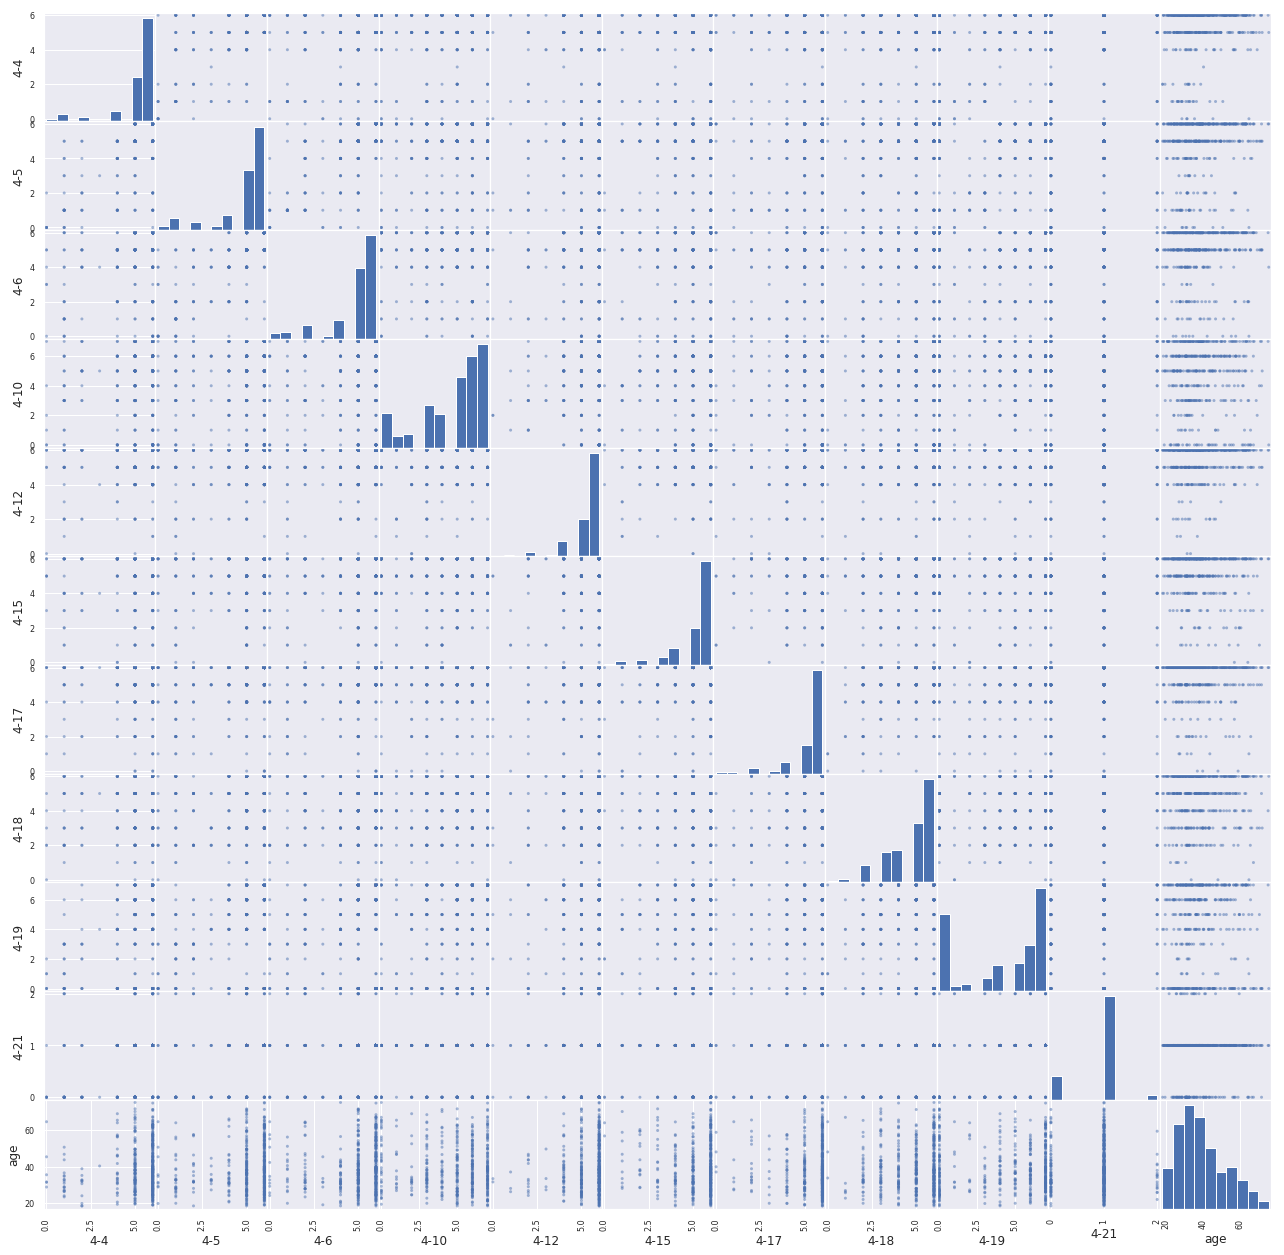

In [13]:
eda.correlation_matrix_plots()

In [14]:
eda.correlation_matrix()

,4-4,4-5,4-6,4-10,4-12,4-15,4-17,4-18,4-19,4-21,age,outcome
4-4,1.000000,0.679507,0.375059,0.207284,0.254400,0.188151,0.187477,0.276971,0.296042,0.375786,0.139424,0.389891
4-5,0.679507,1.000000,0.757631,0.198143,0.266574,0.209874,0.360553,0.316859,0.268722,0.373165,0.141947,0.481221
4-6,0.375059,0.757631,1.000000,0.166157,0.194481,0.199603,0.330414,0.283242,0.156001,0.189385,0.081169,0.452807
4-10,0.207284,0.198143,0.166157,1.000000,0.182104,0.157064,0.154776,0.205630,0.401866,0.086759,-0.038643,0.290997
4-12,0.254400,0.266574,0.194481,0.182104,1.000000,0.253228,0.309994,0.229374,0.041236,0.094749,0.119660,0.303964
4-15,0.188151,0.209874,0.199603,0.157064,0.253228,1.000000,0.223942,0.183134,0.061515,0.031619,-0.070987,0.300525
4-17,0.187477,0.360553,0.330414,0.154776,0.309994,0.223942,1.000000,0.386534,0.073690,0.242883,0.011830,0.328253
4-18,0.276971,0.316859,0.283242,0.205630,0.229374,0.183134,0.386534,1.000000,0.122153,0.218028,0.036121,0.372443
4-19,0.296042,0.268722,0.156001,0.401866,0.041236,0.061515,0.073690,0.122153,1.000000,0.148638,0.004277,0.147708
4-21,0.375786,0.373165,0.189385,0.086759,0.094749,0.031619,0.242883,0.218028,0.148638,1.000000,0.027041,0.261814


In [15]:
def get_age_today(birthday):
    if birthday is not None:
        today =  datetime.datetime.today()
        #print(today, birthday)
        try:
            return (today - birthday).days/365.25
        except TypeError:
            return (today.date() - birthday).days/365.25
    return -1    

import datetime
filtered_all['age'] = filtered_all.apply(lambda row: get_age_today(row['birthday']), axis=1)
raw_copy = fd.raw.copy()
#raw_copy['birthday'] = raw_copy['birthday'].astype('datetime64[ns]')
#raw_copy['age'] = raw_copy.apply(lambda row: get_age_today(row['birthday']), axis=1)

# Relative Variance

In [18]:
explained_variances = eda.pca_explained_variances()
for i, q_id in enumerate(fd.independent_variables):
    print(q_id, round(explained_variances[i],2))

4-4 0.87
4-5 0.05
4-6 0.03
4-10 0.02
4-12 0.01
4-15 0.01
4-17 0.01
4-18 0.01
4-19 0.0
4-21 0.0
age 0.0


# Single Value Decomposition
## Data Projected onto a 2D space, and colored by Outcome

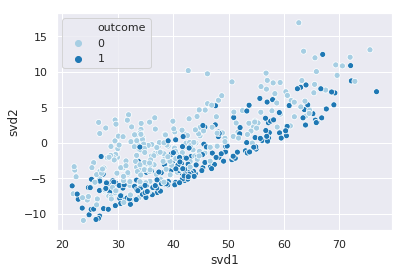

In [19]:
eda.plot_outcome_clusters()

# Logistic Regression
## Histogram of Predicted Probability of Positive Outcome, colored by Actual Outcome


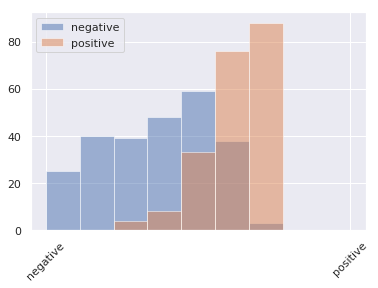

In [20]:
logistic_regression.visualize_goodness()

#
## Results Summary

In [21]:
logistic_regression.print_results()

    Variable      Coefficienct    Standard Error      z    p-Value    lower    upper
--  ----------  --------------  ----------------  -----  ---------  -------  -------
 0  4-4                  0.194             0.168  1.155      0.248   -0.081    0.47
 1  4-5                  0.227             0.225  1.01       0.313   -0.142    0.596
 2  4-6                  0.225             0.173  1.3        0.194   -0.059    0.509
 3  4-10                 0.158             0.114  1.386      0.166   -0.029    0.345
 4  4-12                 0.152             0.125  1.216      0.224   -0.053    0.357
 5  4-15                 0.162             0.114  1.423      0.155   -0.025    0.348
 6  4-17                 0.151             0.129  1.172      0.241   -0.06     0.362
 7  4-18                 0.192             0.117  1.648      0.099    0.001    0.383
 8  4-19                 0.038             0.113  0.338      0.736   -0.147    0.223
 9  4-21                 0.13              0.118  1.101      0.271

# 
## Simulated Probability of Positive Outcome controlling for all but one variable

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


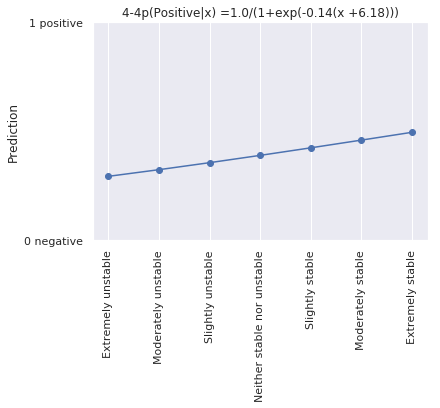

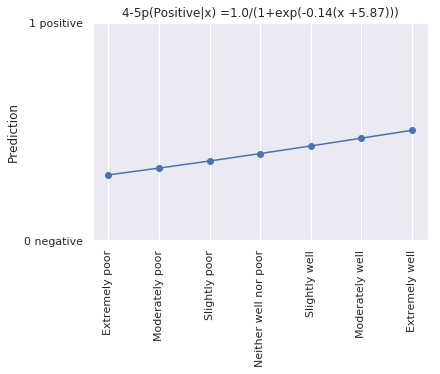

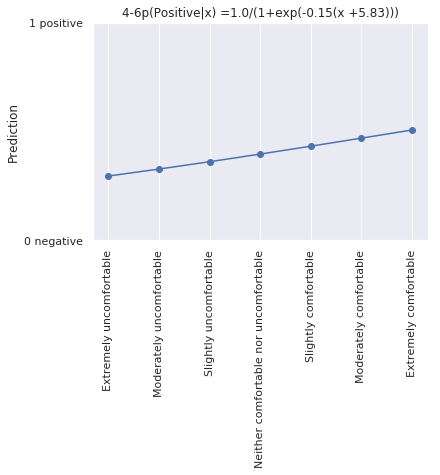

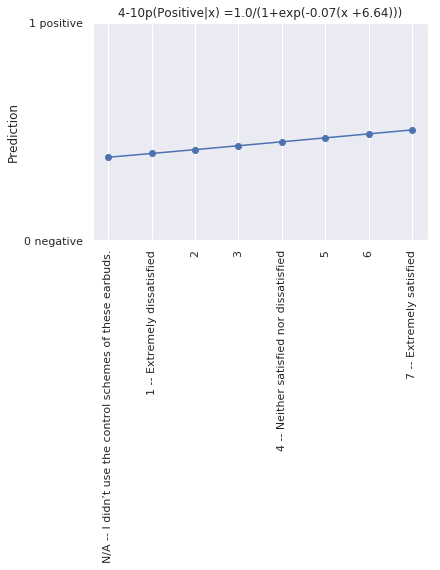

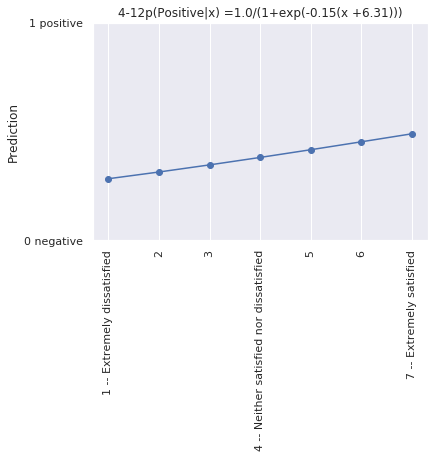

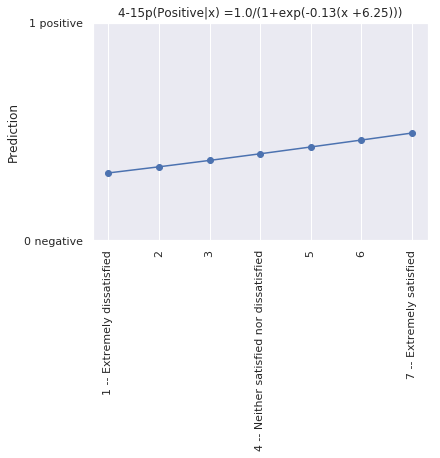

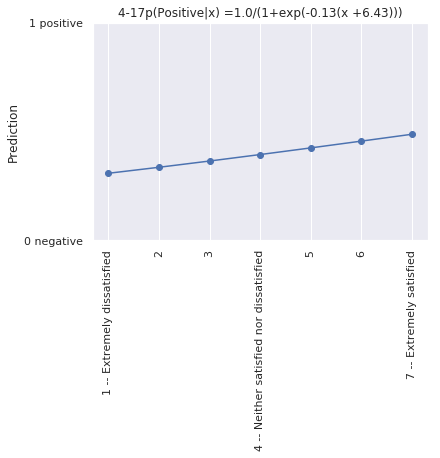

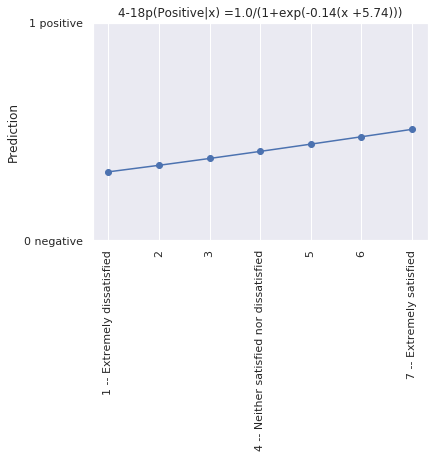

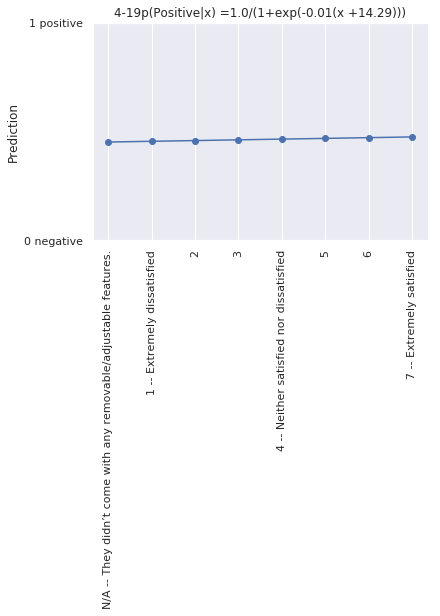

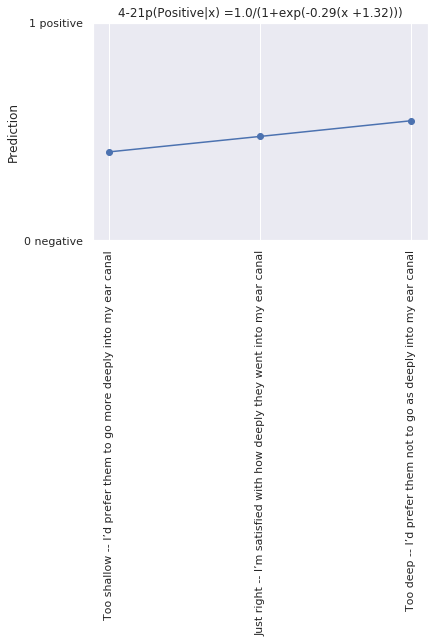

In [22]:
for independent_variable in fd.continuous_independent_variables:
    if independent_variable not in fd.binary_independent_variables:
        logistic_regression.simulate_continuous_outcomes(independent_variable)

In [23]:
for independent_variable in fd.independent_variables:
    if independent_variable in fd.binary_independent_variables or\
       independent_variable in fd.dummies:
        logistic_regression.simulate_binary_outcomes(independent_variable)